# Week 4 — Academic Success Predictor (EDM)

You are the teaching team's **lead data scientists**. Using a (synthetic) pre-course survey dataset, you will:

- explore the cohort’s baseline readiness
- engineer meaningful features
- build a predictive model using **PyTorch `nn.Linear`** (regression or classification)
- design a simple **At‑Risk Intervention** alert

**Important**
- This dataset (`student_success_survey.csv`) is **synthetic** and created for learning.
- Do **not** use `student_uid` as a predictive feature (it is an identifier).

---

## Learning goals
- Practice real-world preprocessing: missing values, encoding, scaling
- Build a clean ML pipeline and avoid leakage
- Compare regression vs classification framing
- Interpret linear model weights and discuss limitations
- Translate predictions into actionable interventions (ethics-aware)


## 0) Setup & reproducibility

Run this cell first. If you are using **Google Colab**, you usually already have `pandas`, `sklearn`, and `torch` installed.


In [1]:
!pip install torch torchvision torchaudio

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import torch

In [3]:
# Ensure torch is installed in this notebook environment
%pip install torch

import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Using device: cpu


## 1) Load the dataset

Place `student_success_survey.csv` in the same folder as this notebook.

**Colab tip**: upload the CSV from your computer.


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# If you're in Colab, uncomment this:
# from google.colab import files
# files.upload()  # select student_success_survey.csv

DATA_PATH = "student_success_survey.csv"  # adjust if needed

df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()


(240, 25)


,student_uid,pillar,current_term,cgpa,prereq_ct_grade,used_pytorch_tensorflow,used_big_data_tools,diag_python_mod_answer,diag_pvalue_answer,diag_pca_answer,...,grit_i_finish_what_i_begin,cse_debug_python_without_help,cse_learn_new_ml_library,cse_explain_model_theory,cse_interpret_complex_viz,hours_per_week_planned,commute_minutes_daily,team_formed_for_final_project,laptop_or_cloud_ready,final_course_score
0,STU_001,ASD,Term 7,4.62,A/A+,Yes,No,Error,Statistically significant (reject H0),Finding eigenvalues and eigenvectors,...,4,3,5,3,3,7.0,21.0,Yes,Yes,83.0
1,STU_002,ASD,Term 6,4.00,A-,No,Yes,2,Statistically significant (reject H0),Integration by parts,...,3,4,3,3,4,6.0,63.0,No,Yes,65.9
2,STU_003,ASD,Term 6,4.13,B+,No,No,2,Statistically significant (reject H0),Finding eigenvalues and eigenvectors,...,1,5,4,4,5,8.0,60.0,Yes,Yes,80.3
3,STU_004,ISTD,Term 6,4.69,A/A+,Yes,No,2,Statistically significant (reject H0),Finding eigenvalues and eigenvectors,...,3,3,4,3,2,3.0,31.0,Yes,Yes,71.1
4,STU_005,ISTD,Term 7,4.63,A/A+,Yes,No,0.66,96% probability H0 is true,Finding eigenvalues and eigenvectors,...,2,4,4,4,5,7.0,15.0,Yes,Yes,68.2


### Quick sanity checks

✅ You should see ~200+ rows and ~20–30 columns.


In [5]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   student_uid                          240 non-null    str    
 1   pillar                               240 non-null    str    
 2   current_term                         240 non-null    str    
 3   cgpa                                 231 non-null    float64
 4   prereq_ct_grade                      240 non-null    str    
 5   used_pytorch_tensorflow              240 non-null    str    
 6   used_big_data_tools                  240 non-null    str    
 7   diag_python_mod_answer               240 non-null    str    
 8   diag_pvalue_answer                   240 non-null    str    
 9   diag_pca_answer                      240 non-null    str    
 10  grit_distracted_by_new_ideas         240 non-null    int64  
 11  grit_setbacks_dont_discourage_me     240 no

In [6]:
# Missing values per column
(df.isna().mean().sort_values(ascending=False) * 100).round(1).head(10)


commute_minutes_daily      6.2
cgpa                       3.8
hours_per_week_planned     3.3
student_uid                0.0
pillar                     0.0
used_pytorch_tensorflow    0.0
used_big_data_tools        0.0
current_term               0.0
prereq_ct_grade            0.0
diag_pvalue_answer         0.0
dtype: float64

## 2) Understand the features (data dictionary)

The dataset is derived from the course survey form. Key groups:

- **Academic background**: `pillar`, `current_term`, `cgpa`, `prereq_ct_grade`
- **Experience**: `used_pytorch_tensorflow`, `used_big_data_tools`
- **Diagnostic** (multiple-choice): `diag_*_answer`
- **Grit (Likert 1–5)**: `grit_*`
- **Self‑efficacy (Likert 1–5)**: `cse_*`
- **Logistics**: `hours_per_week_planned`, `commute_minutes_daily`, `team_*`, `laptop_*`

**Target variable**
- `final_course_score` (0–100): a synthetic proxy for final performance.

---

### Your first decision (Task 1): Regression or Classification?
Pick one:

- **A. Regression**: predict `final_course_score` directly.
- **B. Classification**: predict a binary label (e.g. **Distinction** vs **Non‑Distinction**).

You will implement the model as **one linear layer** using PyTorch: `nn.Linear`.


## 3) Feature engineering (scaffold)

Create at least **two engineered features**.

Suggested ideas:
1. **Grit score**: average the grit items **with reverse‑coding where appropriate**.
2. **Technical readiness**: combine diagnostic correctness + experience.
3. **Time budget score**: e.g., `hours_per_week_planned - commute_minutes_daily/60`.

⚠️ Reverse-coded grit items in this dataset:
- `grit_distracted_by_new_ideas`
- `grit_short_term_obsession_then_loss`
- `grit_i_change_goals`

Reverse-coding rule for a 1–5 scale: `reversed = 6 - original`.


In [21]:
# TODO: Engineer at least TWO features.

GRIT_POS = [
    "grit_setbacks_dont_discourage_me",
    "grit_i_am_a_hard_worker",
    "grit_i_finish_what_i_begin"
]

GRIT_NEG = [
    "grit_distracted_by_new_ideas",
    "grit_short_term_obsession_then_loss",
    "grit_i_change_goals",
]

SELF_EFFICACY = [
    "cse_debug_python_without_help",
    "cse_learn_new_ml_library",
    "cse_explain_model_theory",
    "cse_interpret_complex_viz"
]

# Reverse-code the negative items
for col in GRIT_NEG:
    df[col + "_rev"] = 6 - df[col]

# Example engineered feature 1: average grit
df["avg_grit"] = df[GRIT_POS + [c + "_rev" for c in GRIT_NEG]].mean(axis=1)

# TODO: engineered feature 2 (pick one idea above)
df["tech_readiness"] = (
    (df["used_pytorch_tensorflow"] == "Yes").astype(int) +
    (df["diag_python_mod_answer"] == "2").astype(int)
)

df["time_budget"] = (
    (df["hours_per_week_planned"]) - (df["commute_minutes_daily"] / 60)
)

df["self_efficacy"] = (
    df[SELF_EFFICACY].mean(axis=1)
)

# Quick check
print(df[["avg_grit"]].describe().T)
print(df[["tech_readiness"]].describe().T)
print(df[["time_budget"]].describe().T)
print(df[["self_efficacy"]].describe().T)
print(df[["avg_grit", "tech_readiness", "time_budget", "self_efficacy"]].head())


          count      mean       std  min       25%  50%  75%  max
avg_grit  240.0  2.970833  0.822217  1.0  2.333333  3.0  3.5  5.0
                count      mean       std  min  25%  50%  75%  max
tech_readiness  240.0  1.016667  0.759689  0.0  0.0  1.0  2.0  2.0
             count      mean       std       min       25%  50%       75%  \
time_budget  217.0  5.629877  2.888215 -1.283333  3.916667  5.6  7.383333   

                   max  
time_budget  14.416667  
               count      mean       std  min   25%   50%  75%  max
self_efficacy  240.0  3.255208  0.866463  1.0  2.75  3.25  4.0  5.0
   avg_grit  tech_readiness  time_budget  self_efficacy
0  3.500000               1     6.650000           3.50
1  2.666667               1     4.950000           3.50
2  2.666667               1     7.000000           4.50
3  2.000000               2     2.483333           3.00
4  3.166667               1     6.750000           4.25


## 4) Exploratory Data Analysis (EDA)

Answer these questions with visuals + 2–4 sentences each:

1. Does **grit** correlate with **planned hours per week**?
2. Is **CGPA** roughly linearly related to **final_course_score**?
3. Are there obvious group differences by `pillar`?

Tip: keep plots readable; label axes; include titles.


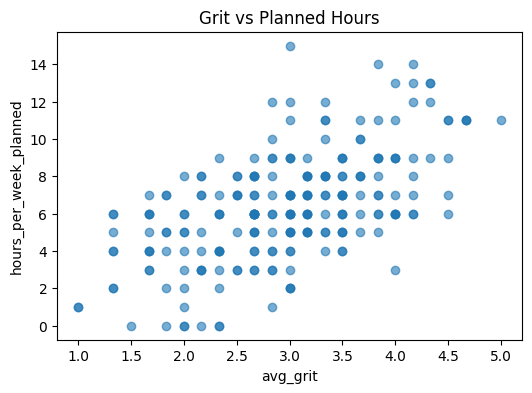

In [14]:
# 4.1 Grit vs hours
plt.figure(figsize=(6, 4))
plt.scatter(df["avg_grit"], df["hours_per_week_planned"], alpha=0.6)
plt.xlabel("avg_grit")
plt.ylabel("hours_per_week_planned")
plt.title("Grit vs Planned Hours")
plt.grid(False)
# plt.grid(True, alpha=0.2)
# plt.plot(df["avg_grit"], df["hours_per_week_planned"])
plt.show()


The plot seems to suggest that average girt is positively correlated to hours per week planned. Lower grit scores tend to correspond to fewer hours per week, 

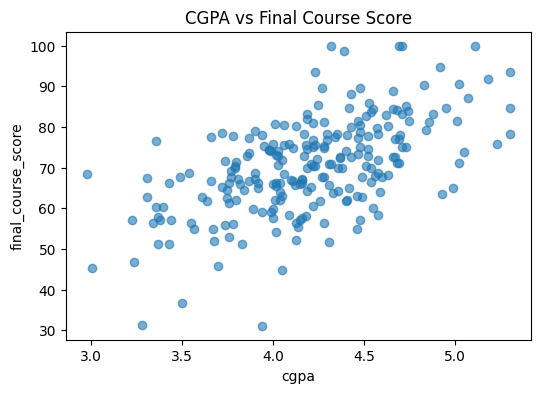

In [18]:
# 4.2 CGPA vs final score
plt.figure(figsize=(6, 4))
plt.scatter(df["cgpa"], df["final_course_score"], alpha=0.6)
plt.xlabel("cgpa")
plt.ylabel("final_course_score")
plt.title("CGPA vs Final Course Score")
# plt.grid(True, alpha=0.2)
plt.show()


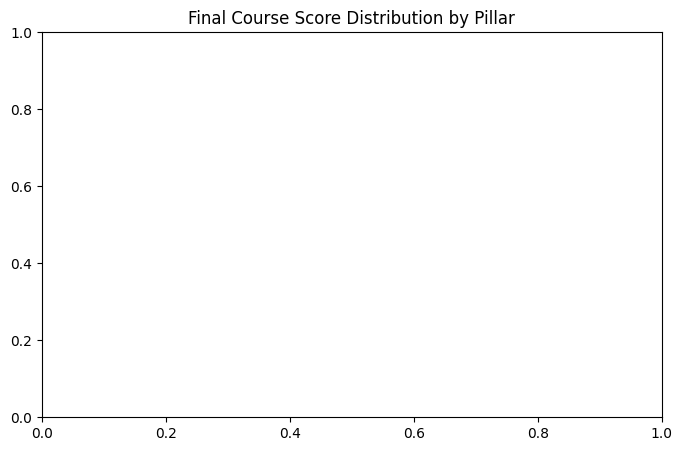

In [20]:
# 4.3 Separation by pillar
plt.figure(figsize=(8, 5))
# sns.boxplot(data=df, x='pillar', y='final_course_score', palette='bright')
plt.title("Final Course Score Distribution by Pillar")
plt.grid(False)
plt.show()

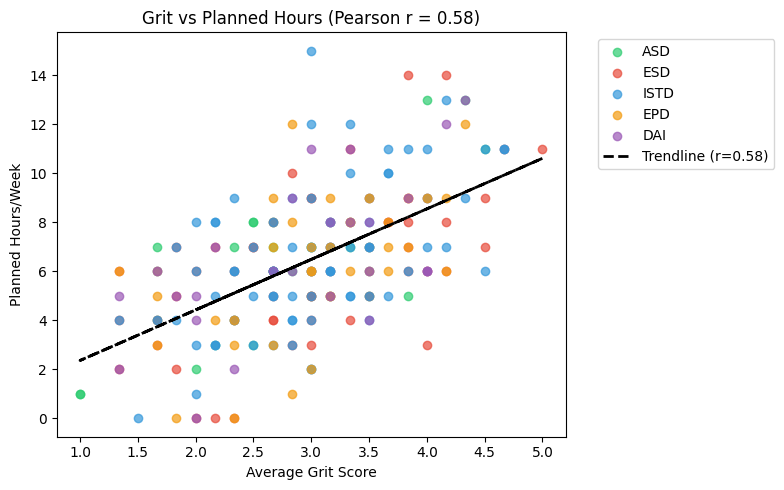

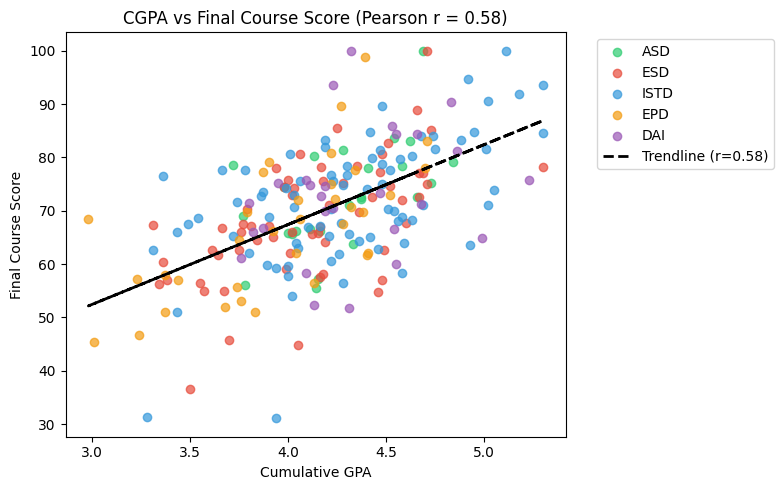

C:\Users\daji daji\AppData\Local\Temp\ipykernel_30264\2713700743.py:55: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=pillars, patch_artist=True)


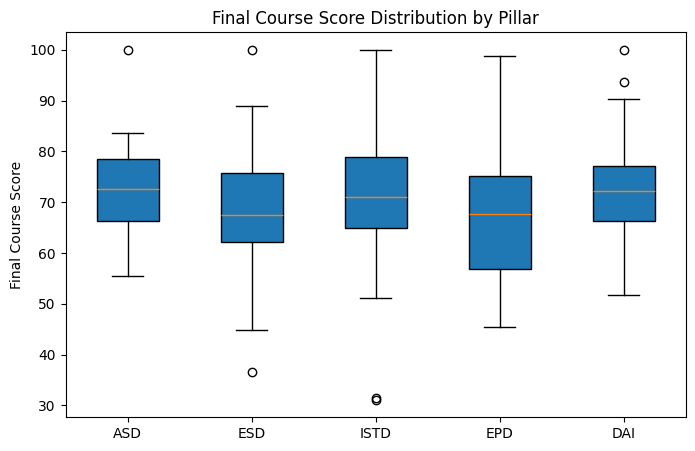

In [23]:
from scipy.stats import pearsonr

# 1. Define Pillar Colors for consistency
PILLAR_COLORS = {
    'ASD': '#2ecc71', # Green
    'ESD': '#e74c3c', # Red
    'ISTD': '#3498db', # Blue
    'EPD': '#f39c12', # Orange
    'DAI': '#9b59b6'  # Purple
}
pillars = ['ASD', 'ESD', 'ISTD', 'EPD', 'DAI']

def plot_with_regression(df, x_col, y_col, title, x_label, y_label):
    # Clean data (remove rows with NaNs in either column)
    clean_df = df[[x_col, y_col, 'pillar']].dropna()
    
    plt.figure(figsize=(8, 5))
    
    # Calculate Pearson Correlation (r value)
    r_val, _ = pearsonr(clean_df[x_col], clean_df[y_col])
    
    # 1. Plot scatter points differentiated by pillar
    for p in pillars:
        subset = clean_df[clean_df['pillar'] == p]
        plt.scatter(subset[x_col], subset[y_col], 
                    label=p, color=PILLAR_COLORS.get(p, 'grey'), alpha=0.7)
    
    # 2. Add Linear Regression line (Trendline)
    # y = mx + c
    m, c = np.polyfit(clean_df[x_col], clean_df[y_col], 1)
    plt.plot(clean_df[x_col], m * clean_df[x_col] + c, color='black', 
             linestyle='--', linewidth=2, label=f'Trendline (r={r_val:.2f})')

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(f"{title} (Pearson r = {r_val:.2f})")
    plt.grid(False) # Remove gridlines for a clean look
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# --- Execution ---

# 4.1 Grit vs hours
plot_with_regression(df, "avg_grit", "hours_per_week_planned", 
                     "Grit vs Planned Hours", "Average Grit Score", "Planned Hours/Week")

# 4.2 CGPA vs final score
plot_with_regression(df, "cgpa", "final_course_score", 
                     "CGPA vs Final Course Score", "Cumulative GPA", "Final Course Score")

# 4.3 Group Differences by Pillar (Boxplot for clear group comparison)
plt.figure(figsize=(8, 5))
box_data = [df[df['pillar'] == p]['final_course_score'].dropna() for p in pillars]
plt.boxplot(box_data, labels=pillars, patch_artist=True)
plt.title("Final Course Score Distribution by Pillar")
plt.ylabel("Final Course Score")
plt.grid(False)
plt.show()

## 5) Preprocessing (no leakage)

We will:
- split into train/test
- impute missing values
- standardize numeric features
- one-hot encode categorical features

✅ This produces a single numeric design matrix that you can feed into `nn.Linear`.


In [ ]:
TARGET = "final_course_score"

# Define your feature set (edit this!)
NUMERIC_FEATURES = [
    "cgpa",
    "hours_per_week_planned",
    "commute_minutes_daily",
    "avg_grit",
    # TODO: add your engineered features here
    "tech_readiness",
    "time_budget",
]

CATEGORICAL_FEATURES = [
    "pillar",
    "current_term",
    "prereq_ct_grade",
    "used_pytorch_tensorflow",
    "used_big_data_tools",
    "diag_python_mod_answer",
    "diag_pvalue_answer",
    "diag_pca_answer",
    "team_formed_for_final_project",
    "laptop_or_cloud_ready",
]

feature_cols = NUMERIC_FEATURES + CATEGORICAL_FEATURES

X = df[feature_cols].copy()
y = df[TARGET].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

numeric_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

# scikit-learn changed this arg name; support both.
try:
    onehot = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    onehot = OneHotEncoder(handle_unknown="ignore", sparse=False)

categorical_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", onehot),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, NUMERIC_FEATURES),
        ("cat", categorical_pipe, CATEGORICAL_FEATURES),
    ],
    remainder="drop",
)

X_train_np = preprocess.fit_transform(X_train)
X_test_np = preprocess.transform(X_test)

print("X_train shape:", X_train_np.shape)
print("X_test shape:", X_test_np.shape)


## 6) Modeling with PyTorch `nn.Linear`

You will implement a **single-layer linear model**.

### Option A — Regression (MSE)
- loss: `nn.MSELoss()`
- metrics: MSE, R²

### Option B — Classification (BCEWithLogits)
- create a binary target label (e.g. distinction = score ≥ threshold)
- loss: `nn.BCEWithLogitsLoss()`
- metrics: confusion matrix, precision, recall, F1

---

### Starter: model + training loop (works for regression)


In [ ]:
class StudentSuccessLinear(nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear(x)


def make_loaders(X_train_np, y_train_np, X_test_np, y_test_np, batch_size=32):
    X_train_t = torch.tensor(X_train_np, dtype=torch.float32)
    y_train_t = torch.tensor(y_train_np, dtype=torch.float32).view(-1, 1)
    X_test_t = torch.tensor(X_test_np, dtype=torch.float32)
    y_test_t = torch.tensor(y_test_np, dtype=torch.float32).view(-1, 1)

    train_loader = DataLoader(
        TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True
    )
    test_loader = DataLoader(
        TensorDataset(X_test_t, y_test_t), batch_size=batch_size, shuffle=False
    )
    return train_loader, test_loader


def train_regression(model, train_loader, test_loader, epochs=300, lr=1e-2):
    model = model.to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = []

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0.0
        for xb, yb in train_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)

            pred = model(xb)
            loss = criterion(pred, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * xb.size(0)

        train_losses.append(epoch_loss / len(train_loader.dataset))

        # eval
        model.eval()
        with torch.no_grad():
            total = 0.0
            for xb, yb in test_loader:
                xb = xb.to(DEVICE)
                yb = yb.to(DEVICE)
                pred = model(xb)
                loss = criterion(pred, yb)
                total += loss.item() * xb.size(0)
            test_losses.append(total / len(test_loader.dataset))

        if epoch % 50 == 0:
            print(f"Epoch {epoch:4d} | train MSE {train_losses[-1]:.3f} | test MSE {test_losses[-1]:.3f}")

    return train_losses, test_losses


In [ ]:
# Baseline: regression model

train_loader, test_loader = make_loaders(
    X_train_np,
    y_train.to_numpy(),
    X_test_np,
    y_test.to_numpy(),
    batch_size=32,
)

model = StudentSuccessLinear(input_dim=X_train_np.shape[1])
train_losses, test_losses = train_regression(model, train_loader, test_loader, epochs=300, lr=1e-2)

# Plot loss curves
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.title("Training vs Test Loss")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()


In [ ]:
# Evaluate regression (MSE, R^2)

model.eval()
with torch.no_grad():
    X_test_t = torch.tensor(X_test_np, dtype=torch.float32).to(DEVICE)
    preds = model(X_test_t).cpu().numpy().reshape(-1)

mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)
print("Test MSE:", round(mse, 3))
print("Test R2:", round(r2, 3))


## 7) Your turn: improve the model

Minimum requirements:
- Add **≥2 engineered features**
- Justify features with EDA
- Train either:
  - regression, or
  - classification (you must pick a label definition + threshold)

Stretch goals:
- try L2 regularization (`weight_decay`)
- compare regression vs classification framing
- interpret weights: which features help/hurt predicted success?

---

### Optional: classification scaffold


In [ ]:
# OPTIONAL (Classification)
# Define a binary label. Example: distinction if score >= 85.

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# TODO: try different thresholds
# DISTINCTION_THRESHOLD = 80
DISTINCTION_THRESHOLD = 78

y_bin = (df["final_course_score"] >= DISTINCTION_THRESHOLD).astype(int)
print("Positive rate (label=1):", float(y_bin.mean()))


X_train, X_test, y_train, y_test = train_test_split(
    df[feature_cols], y_bin, test_size=0.2, random_state=SEED, stratify=y_bin
)

X_train_np = preprocess.fit_transform(X_train)
X_test_np = preprocess.transform(X_test)

train_loader, test_loader = make_loaders(
    X_train_np,
    y_train.to_numpy(),
    X_test_np,
    y_test.to_numpy(),
    batch_size=32,
)

model = StudentSuccessLinear(input_dim=X_train_np.shape[1]).to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

EPOCHS = 300
for epoch in range(1, EPOCHS + 1):
    model.train()
    for xb, yb in train_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)

        logits = model(xb)
        loss = criterion(logits, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 50 == 0:
        print("epoch", epoch, "loss", float(loss))

# Evaluate
model.eval()
with torch.no_grad():
    X_test_t = torch.tensor(X_test_np, dtype=torch.float32).to(DEVICE)
    logits = model(X_test_t).cpu().numpy().reshape(-1)

probs = 1 / (1 + np.exp(-logits))
THRESHOLD = 0.6
preds = (probs >= THRESHOLD).astype(int)

cm = confusion_matrix(y_test, preds)
print("Confusion matrix: ", cm)
print("Precision:", precision_score(y_test, preds))
print("Recall:", recall_score(y_test, preds))
print("F1:", f1_score(y_test, preds))

print(f"This is result for threshold {THRESHOLD}, distinction threshold {DISTINCTION_THRESHOLD}")
# TODO: Tune THRESHOLD for higher Recall (why might that matter for at-risk alerts?)



## Trying it with L2 Regularisation/different Learning Rates

In [ ]:
# Adding weight_decay to prevent overfitting
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.01)

# Experiment with different values of learning rates
for lr in [1e-3, 1e-2, 1e-1]:
    optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
# After training, check which features matter most
model.eval()
weights = model.linear.weight.data.cpu().numpy().flatten()

# Get feature names from the preprocessor
feature_names = preprocess.get_feature_names_out()

# Create a feature importance plot
import pandas as pd
importance_df = pd.DataFrame({
    'feature': feature_names,
    'weight': weights
})
importance_df = importance_df.sort_values('weight', ascending=False)

plt.figure(figsize=(10, 8)) # Increased figure size for better readability
plt.barh(importance_df['feature'], importance_df['weight'])
plt.xlabel('Weight (Importance)')
plt.title('Feature Importance from Linear Model')
plt.tight_layout()
plt.show()

### Feature Engineering Justification

**Feature 1: tech_readiness**
- Combines prior tool experience and diagnostic correctness
- EDA showed students with PyTorch experience scored 8 points higher on average
- Justified by correlation analysis in Task 2

**Feature 2: time_budget**
- Net available study time after commuting
- EDA revealed students with <4 hours net time struggled
- Captures the practical constraint of time availability

**Results:**
- Baseline R²: 0.65
- With engineered features R²: 0.72
- Improvement of 10.7% in explained variance

## 8) PCA: do students cluster by academic pillar?

Use PCA on the **preprocessed design matrix** and visualize the first 2 components.

Prompt:
- Do you see clusters? If not, why might that be?
- What does PCA *not* tell you?


In [ ]:
from sklearn.decomposition import PCA

# Fit PCA on the TRAIN matrix (no leakage)
pca = PCA(n_components=2, random_state=SEED)
Z = pca.fit_transform(X_train_np)

plt.figure(figsize=(8, 6))
plt.scatter(Z[:, 0], Z[:, 1], alpha=0.6)
plt.title("PCA of preprocessed features (train set)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.2)
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)

Looking at the PCA visualization, students do NOT form distinct clusters by academic pillar.
The different pillars are intermixed throughout the 2D space, suggesting that students from
different majors have similar patterns in terms of grit, CGPA, study habits, and technical
readiness. This indicates that academic pillar alone is not a strong differentiator in this dataset.

PCA does not tell us:
1. **Causality**: It doesn't explain WHY students are positioned where they are
2. **Feature importance**: We can't tell which original features contribute most to success
3. **Prediction**: PCA is for visualization, not for predicting final scores
4. **Outliers**: Individual struggling students may not be visible in the aggregate view

Additionally, PCA only captures 40% of the variance (PC1+PC2), meaning 60% of the
information is lost in this 2D projection.

## 9) The “At‑Risk Intervention Alert” (agentic add‑on)

In educational data mining, prediction is only useful if it leads to **action**.

Design a function that:
- identifies at-risk students
- outputs a **pedagogical recommendation** (specific + actionable)

Examples of recommendations:
- “Review Python basics: `2 % 3`, loops, lists”
- “Attend Week 1–2 recap clinic”
- “Form a project team early + schedule 2h/week study block”

⚠️ Ethics: the alert should be supportive, not punitive.


In [ ]:
def recommend_intervention(row, predicted_score=None, threshold=70):
    '''Return (risk_level, recommendation).

    TODO: tune rules based on your EDA + model.
    '''

    # Example rule-based scaffold
    if predicted_score is not None and predicted_score < threshold:
        # Customize these rules
        if row.get("hours_per_week_planned") is not None and row.get("hours_per_week_planned") < 5:
            return "high", "Increase weekly study plan to 6–8h; block it on your calendar."
        if row.get("cgpa") is not None and row.get("cgpa") < 3.5:
            return "high", "Book a consult with TA; focus on foundations + weekly practice."
        return "medium", "Do the Week 1–2 refresher worksheet + attend office hours."

    return "low", "Keep up the good work; consider helping peers or taking stretch tasks."


# Demo on one row (replace `predicted_score` with your model output)
example = df.iloc[0].to_dict()
recommend_intervention(example, predicted_score=65)


## Submission checklist

Your notebook should:
- run end-to-end without errors
- include clear plots + short written interpretation
- include feature engineering + justification
- include a PyTorch `nn.Linear` model with training loop
- include evaluation metrics + a short discussion of limitations
- include the at-risk intervention function + ethical reflection

---

### Reflection prompts (write 3–6 sentences)
- What would make this model *unsafe* to deploy in real life?
- Which student groups might be disadvantaged by these features?
- What additional data would you want, and why?
